In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sea
import random
import tensorflow as tf
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn import svm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
from IPython.display import display
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neighbors import NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from lightgbm import LGBMClassifier
from sklearn import svm
from IPython.display import clear_output
import xgboost as xgb
import pickle

In [7]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [8]:
# load pretrained MobileNet
pre_trained_model = MobileNet(input_shape=(224,224,3), include_top=True)
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [9]:
vector = pre_trained_model.get_layer("reshape_2").output
feature_extractor = tf.keras.Model(pre_trained_model.input, vector)

In [10]:
labels = ['bellflower','daisy','dandelion','tulip','sunflower','rose','lotus','iris']
path = "D:/school/ML/Machine_Learning_Project/Data/train"

# create empty feature and label lists
x_list_train = []
y_list_train = []

for f in range(8):
    folder_path = os.path.join(path, labels[f])
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        # load image
        img = Image.open(file_path).convert("RGB")
        img = img.resize((224, 224))
        img = np.array(img)
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)
        img_arr = np.uint8(np.absolute(laplacian))
        # convert image to numpy array
        
        # add 1 more dimension
        img_arr = np.expand_dims(img_arr, axis=2)
        img_arr = np.repeat(img_arr, 3, axis=2)
        img_arr = np.expand_dims(img_arr, axis=0)
        # preprocess image
        input_img = preprocess_input(img_arr)
        # extract feature
        feature_vec = feature_extractor.predict(input_img)
        x_list_train.append(feature_vec.ravel())
        y_list_train.append(f)
        clear_output(wait=True)

1/1 [==============================] - 0s 121ms/step


In [11]:
x_train_temp = np.asarray(x_list_train, dtype=np.float32)
y_train_temp = np.asarray(y_list_train, dtype=np.float32)

for s in range(100):
    x_train_temp, y_train_temp = shuffle(x_train_temp, y_train_temp)
with open('x_train_nocolor.pkl', 'wb') as file:
    pickle.dump(x_train_temp, file)
with open('y_train_nocolor.pkl', 'wb') as file:
    pickle.dump(y_train_temp, file)

print("Shape of feature matrix X")
print(x_train_temp.shape)
print("\nShape of label matrix Y")
print(y_train_temp.shape)

class_types, counts = np.unique(y_train_temp, return_counts=True)

print("\nClass labels")
print(class_types)
print("\nClass counts")
print(counts)

Shape of feature matrix X
(16137, 1000)

Shape of label matrix Y
(16137,)

Class labels
[0. 1. 2. 3. 4. 5. 6. 7.]

Class counts
[2013 2030 2000 2000 2001 2073 2001 2019]


In [12]:
labels = ['bellflower','daisy','dandelion','tulip','sunflower','rose','lotus','iris']
path = "D:/school/ML/Machine_Learning_Project/Data/test"

# create empty feature and label lists
x_list = []
y_list = []

for f in range(8):
    folder_path = os.path.join(path, labels[f])
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        # load image
        img = Image.open(file_path).convert("RGB")
        img = img.resize((224, 224))
        img = np.array(img)
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)
        img_arr = np.uint8(np.absolute(laplacian))
        # convert image to numpy array
        
        # add 1 more dimension
        img_arr = np.expand_dims(img_arr, axis=2)
        img_arr = np.repeat(img_arr, 3, axis=2)
        img_arr = np.expand_dims(img_arr, axis=0)
        # preprocess image
        input_img = preprocess_input(img_arr)
        # extract feature
        feature_vec = feature_extractor.predict(input_img)
        x_list.append(feature_vec.ravel())
        y_list.append(f)
        clear_output(wait=True)
     

1/1 [==============================] - 0s 132ms/step


In [13]:
x_test = np.asarray(x_list, dtype=np.float32)
y_test = np.asarray(y_list, dtype=np.float32)
with open('x_test_nocolor.pkl', 'wb') as file:
    pickle.dump(x_test, file)
with open('y_test_nocolor.pkl', 'wb') as file:
    pickle.dump(y_test, file)


In [15]:
with open('x_test_color.pkl', 'rb') as file:
    x_test_color = pickle.load(file)
with open('y_test_color.pkl', 'rb') as file:
    y_test_color = pickle.load(file)


In [16]:
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.125, stratify=y_train_temp, random_state=40)

print("Shape of train_X")
print(x_train.shape)
print("\nShape of test_X")
print(x_test.shape)

Shape of train_X
(14119, 1000)

Shape of test_X
(4000, 1000)


## CONFUSION MATRIX

In [18]:
class ConfusionMatrixPlot:
    def __init__(self, labels, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.labels = labels
    def plot(self):
        conf_matrix = confusion_matrix(y_true=self.y_true, y_pred=self.y_pred)
        plt.figure(figsize = (8,8))
        sns.heatmap(conf_matrix, annot=True, linecolor = 'black' , linewidth = 1, fmt='', cmap="Blues", xticklabels = self.labels , yticklabels = self.labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix Of Best Model')
        plt.show()

## CLASSIFICATION REPORT

In [19]:
class ClassificationReportPlot:
    def __init__(self,labels, true_labels, predicted_labels):
        self.true_labels = true_labels
        self.predicted_labels = predicted_labels
        self.labels = labels
    def plot(self):
        report = classification_report(self.true_labels, self.predicted_labels, target_names=labels, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        pd.set_option("display.max_rows", None)
        report_df.style.set_properties(**{'border-color': 'black', 'border-style': 'solid'})
        display(report_df)
        plt.show()

## K NEAREST NEIGHBOR

Best Model: KNeighborsClassifier(n_neighbors=9,
                     weights=<function weight2 at 0x0000020C49FEBE20>)


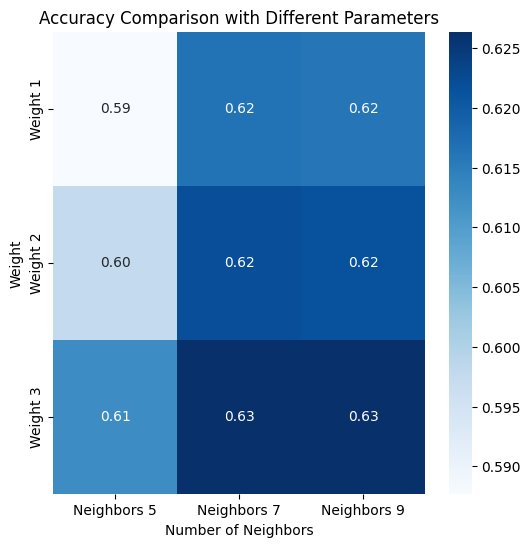

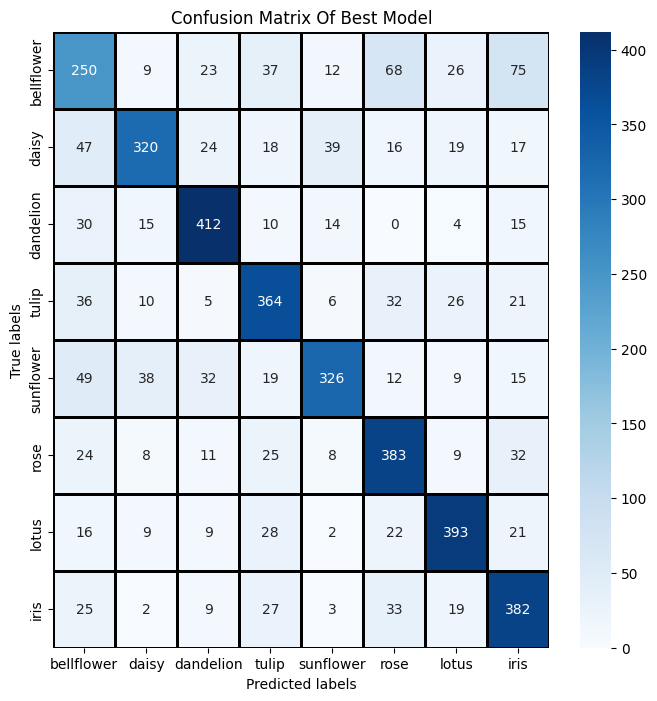

,precision,recall,f1-score,support
bellflower,0.524109,0.5000,0.511771,500.0000
daisy,0.778589,0.6400,0.702525,500.0000
dandelion,0.784762,0.8240,0.803902,500.0000
tulip,0.689394,0.7280,0.708171,500.0000
sunflower,0.795122,0.6520,0.716484,500.0000
rose,0.676678,0.7660,0.718574,500.0000
lotus,0.778218,0.7860,0.782090,500.0000
iris,0.660900,0.7640,0.708720,500.0000
accuracy,0.707500,0.7075,0.707500,0.7075
macro avg,0.710971,0.7075,0.706530,4000.0000


In [20]:
from sklearn.model_selection import GridSearchCV
def weight1(distances):
    return distances
def weight2(distances):
    return 1 / distances**2
def weight3(distances):
    return 1 / distances
param_grid = {
    'n_neighbors': [5, 7, 9],
    'weights': [weight1, weight2, weight3]
}
KNN = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=KNN, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_val, y_val)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
best_model.fit(x_train_temp,y_train_temp)
y_pred = best_model.predict(x_test)
mean_test_scores = grid_search.cv_results_['mean_test_score']
parameters = grid_search.cv_results_['params']
data = pd.DataFrame(mean_test_scores.reshape(len(param_grid['weights']), len(param_grid['n_neighbors'])),
                    index=[f'Weight {i+1}' for i in range(len(param_grid['weights']))],
                    columns=[f'Neighbors {j}' for j in param_grid['n_neighbors']])
plt.figure(figsize=(6, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel('Number of Neighbors')
plt.ylabel('Weight')
plt.title('Accuracy Comparison with Different Parameters')
plt.show()
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()


In [21]:
y_pred=best_model.predict(x_test_color)
report_plot = ClassificationReportPlot(labels, y_test_color, y_pred)
report_plot.plot()

,precision,recall,f1-score,support
bellflower,0.361702,0.51000,0.423237,500.00000
daisy,0.228604,0.79600,0.355199,500.00000
dandelion,0.929825,0.31800,0.473920,500.00000
tulip,0.426184,0.30600,0.356228,500.00000
sunflower,0.527197,0.50400,0.515337,500.00000
rose,0.878378,0.13000,0.226481,500.00000
lotus,0.403226,0.35000,0.374732,500.00000
iris,0.578947,0.04400,0.081784,500.00000
accuracy,0.369750,0.36975,0.369750,0.36975
macro avg,0.541758,0.36975,0.350865,4000.00000


## SVM

In [22]:
from sklearn import svm

param_grid = {'C': [1,2,5], 'gamma': [0.002, 0.0005, 0.001]}

svm = svm.SVC(kernel='rbf')
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_val, y_val)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
best_model.fit(x_train_temp,y_train_temp)
y_pred = best_model.predict(x_test)
mean_test_scores = grid_search.cv_results_['mean_test_score']
parameters = grid_search.cv_results_['params']


Best Model: SVC(C=2, gamma=0.0005)


In [23]:
param_grid

{'C': [1, 2, 5], 'gamma': [0.002, 0.0005, 0.001]}

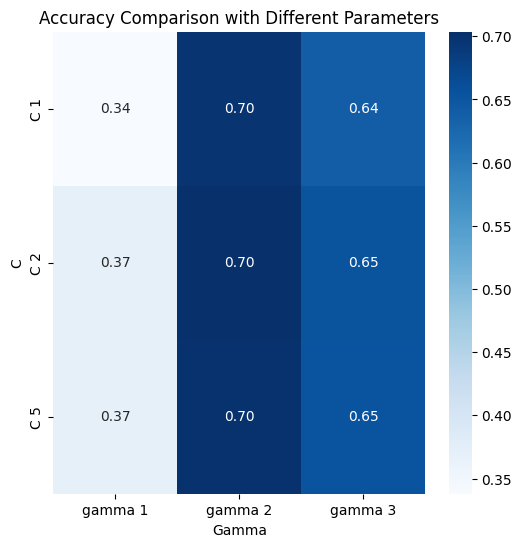

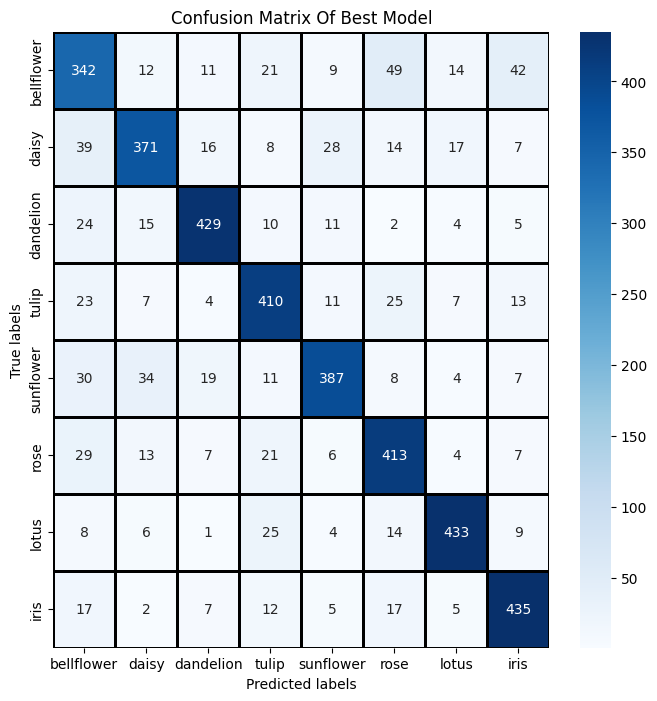

,precision,recall,f1-score,support
bellflower,0.667969,0.684,0.675889,500.000
daisy,0.806522,0.742,0.772917,500.000
dandelion,0.868421,0.858,0.863179,500.000
tulip,0.791506,0.820,0.805501,500.000
sunflower,0.839479,0.774,0.805411,500.000
rose,0.761993,0.826,0.792706,500.000
lotus,0.887295,0.866,0.876518,500.000
iris,0.828571,0.870,0.848780,500.000
accuracy,0.805000,0.805,0.805000,0.805
macro avg,0.806469,0.805,0.805113,4000.000


In [24]:
data = pd.DataFrame(
    np.array(mean_test_scores).reshape(len(param_grid['C']), len(param_grid['gamma'])),
    index=[f'C {i}' for i in param_grid['C']],
    columns=[f'gamma {j+1}' for j in range(len(param_grid['gamma']))])
plt.figure(figsize=(6, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('Accuracy Comparison with Different Parameters')
plt.show()
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

In [25]:
y_pred=best_model.predict(x_test_color)
report_plot = ClassificationReportPlot(labels, y_test_color, y_pred)
report_plot.plot()

d:\App\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\App\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\App\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
bellflower,0.550117,0.4720,0.508073,500.0000
daisy,0.165295,0.9640,0.282201,500.0000
dandelion,0.941176,0.0320,0.061896,500.0000
tulip,0.523256,0.0900,0.153584,500.0000
sunflower,0.884848,0.2920,0.439098,500.0000
rose,0.980000,0.0980,0.178182,500.0000
lotus,0.581602,0.3920,0.468339,500.0000
iris,0.000000,0.0000,0.000000,500.0000
accuracy,0.292500,0.2925,0.292500,0.2925
macro avg,0.578287,0.2925,0.261422,4000.0000


## XGBOOST


Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


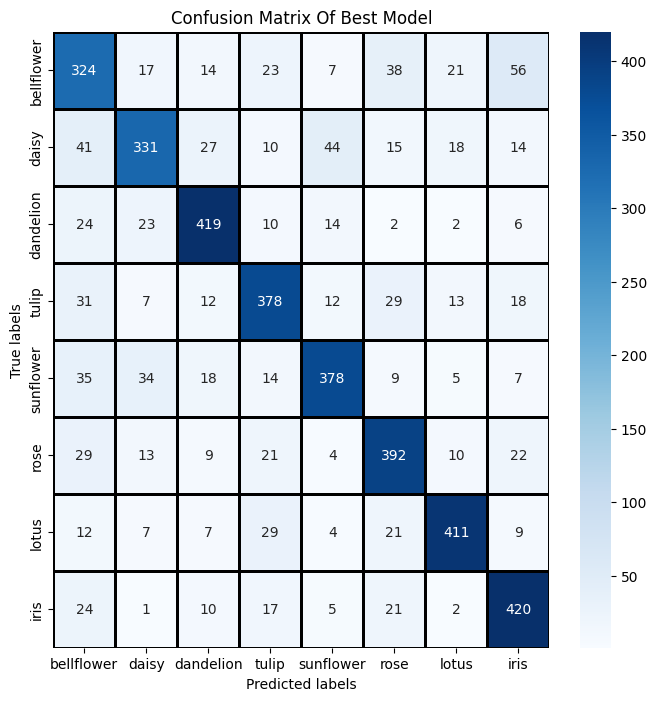

,precision,recall,f1-score,support
bellflower,0.623077,0.64800,0.635294,500.00000
daisy,0.764434,0.66200,0.709539,500.00000
dandelion,0.812016,0.83800,0.824803,500.00000
tulip,0.752988,0.75600,0.754491,500.00000
sunflower,0.807692,0.75600,0.780992,500.00000
rose,0.743833,0.78400,0.763389,500.00000
lotus,0.852697,0.82200,0.837067,500.00000
iris,0.760870,0.84000,0.798479,500.00000
accuracy,0.763250,0.76325,0.763250,0.76325
macro avg,0.764701,0.76325,0.763007,4000.00000


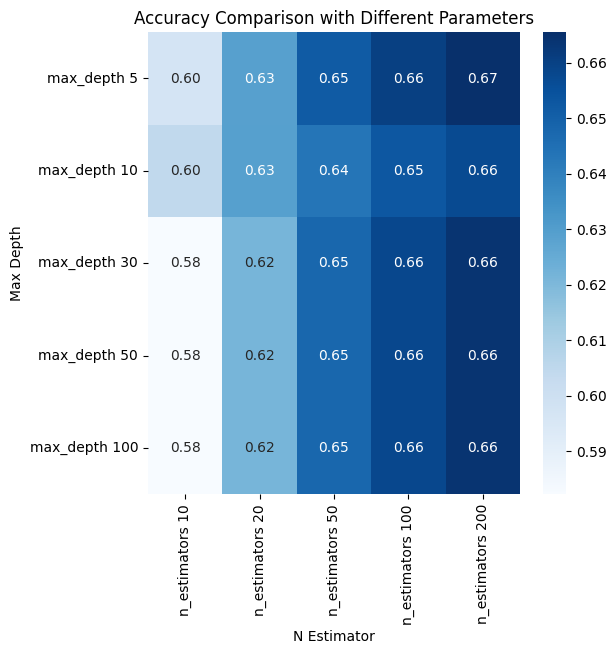

In [26]:
param_grid = {
    'max_depth': [5,10,30,50,100],
    'n_estimators': [10,20,50,100,200]
}
XGBoost = XGBClassifier(random_state=50, n_jobs=-1)
grid_search = GridSearchCV(estimator=XGBoost, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_val, y_val)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
best_model.fit(x_train_temp,y_train_temp)
y_pred = best_model.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()
mean_test_scores = grid_search.cv_results_['mean_test_score']
parameters = grid_search.cv_results_['params']
data = pd.DataFrame(mean_test_scores.reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])),
                    index=[f'max_depth {i}' for i in param_grid['max_depth']],
                    columns=[f'n_estimators {j}' for j in param_grid['n_estimators']])
plt.figure(figsize=(6, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel('N Estimator')
plt.ylabel('Max Depth')
plt.title('Accuracy Comparison with Different Parameters')
plt.show()

In [27]:
y_pred=best_model.predict(x_test_color)
report_plot = ClassificationReportPlot(labels, y_test_color, y_pred)
report_plot.plot()

,precision,recall,f1-score,support
bellflower,0.427640,0.6560,0.517758,500.0000
daisy,0.388439,0.6720,0.492308,500.0000
dandelion,0.922481,0.2380,0.378378,500.0000
tulip,0.549249,0.6580,0.598726,500.0000
sunflower,0.528937,0.7860,0.632341,500.0000
rose,0.901961,0.1840,0.305648,500.0000
lotus,0.491736,0.7140,0.582382,500.0000
iris,0.869565,0.1200,0.210896,500.0000
accuracy,0.503500,0.5035,0.503500,0.5035
macro avg,0.635001,0.5035,0.464805,4000.0000


Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


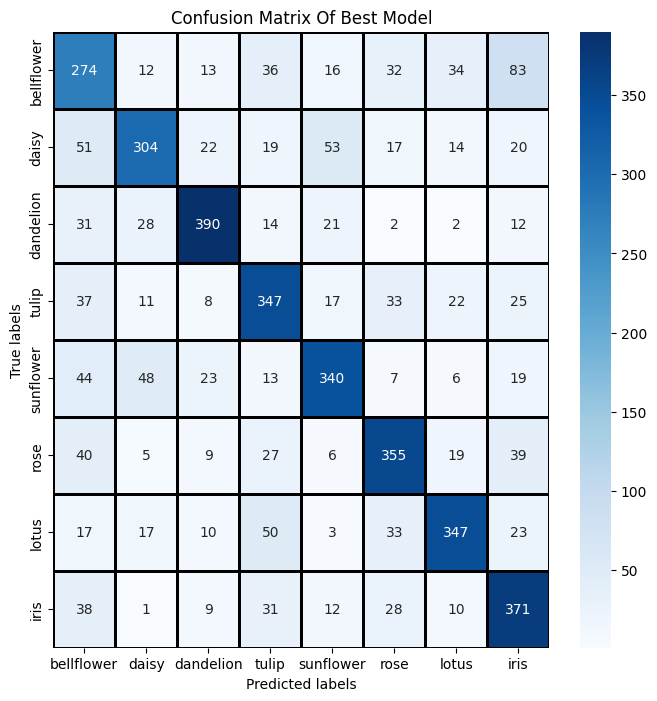

,precision,recall,f1-score,support
bellflower,0.515038,0.548,0.531008,500.000
daisy,0.713615,0.608,0.656587,500.000
dandelion,0.805785,0.780,0.792683,500.000
tulip,0.646182,0.694,0.669238,500.000
sunflower,0.726496,0.680,0.702479,500.000
rose,0.700197,0.710,0.705065,500.000
lotus,0.764317,0.694,0.727463,500.000
iris,0.626689,0.742,0.679487,500.000
accuracy,0.682000,0.682,0.682000,0.682
macro avg,0.687290,0.682,0.683001,4000.000


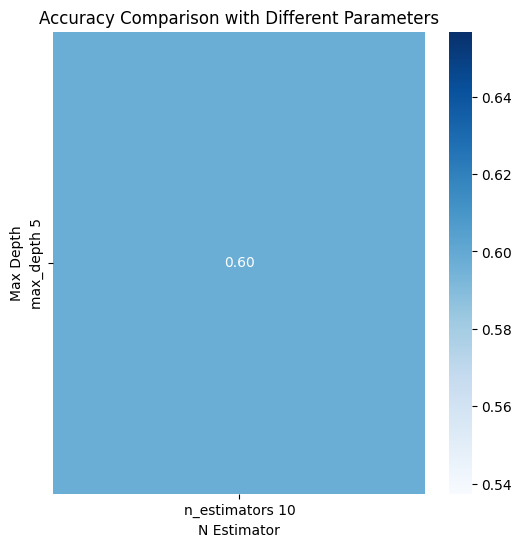

In [28]:
param_grid = {
    'max_depth': [5],
    'n_estimators': [10]
}
XGBoost = XGBClassifier(random_state=50, n_jobs=-1)
grid_search = GridSearchCV(estimator=XGBoost, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_val, y_val)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
best_model.fit(x_train_temp,y_train_temp)
y_pred = best_model.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()
mean_test_scores = grid_search.cv_results_['mean_test_score']
parameters = grid_search.cv_results_['params']
data = pd.DataFrame(mean_test_scores.reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])),
                    index=[f'max_depth {i}' for i in param_grid['max_depth']],
                    columns=[f'n_estimators {j}' for j in param_grid['n_estimators']])
plt.figure(figsize=(6, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel('N Estimator')
plt.ylabel('Max Depth')
plt.title('Accuracy Comparison with Different Parameters')
plt.show()

In [32]:
y_pred=best_model.predict(x_test_color)
report_plot = ClassificationReportPlot(labels, y_test_color, y_pred)
report_plot.plot()

,precision,recall,f1-score,support
bellflower,0.385965,0.30800,0.342603,500.00000
daisy,0.486000,0.48600,0.486000,500.00000
dandelion,0.609626,0.22800,0.331878,500.00000
tulip,0.407867,0.78800,0.537517,500.00000
sunflower,0.421260,0.85600,0.564644,500.00000
rose,0.649819,0.36000,0.463320,500.00000
lotus,0.627615,0.30000,0.405954,500.00000
iris,0.653846,0.54400,0.593886,500.00000
accuracy,0.483750,0.48375,0.483750,0.48375
macro avg,0.530250,0.48375,0.465725,4000.00000


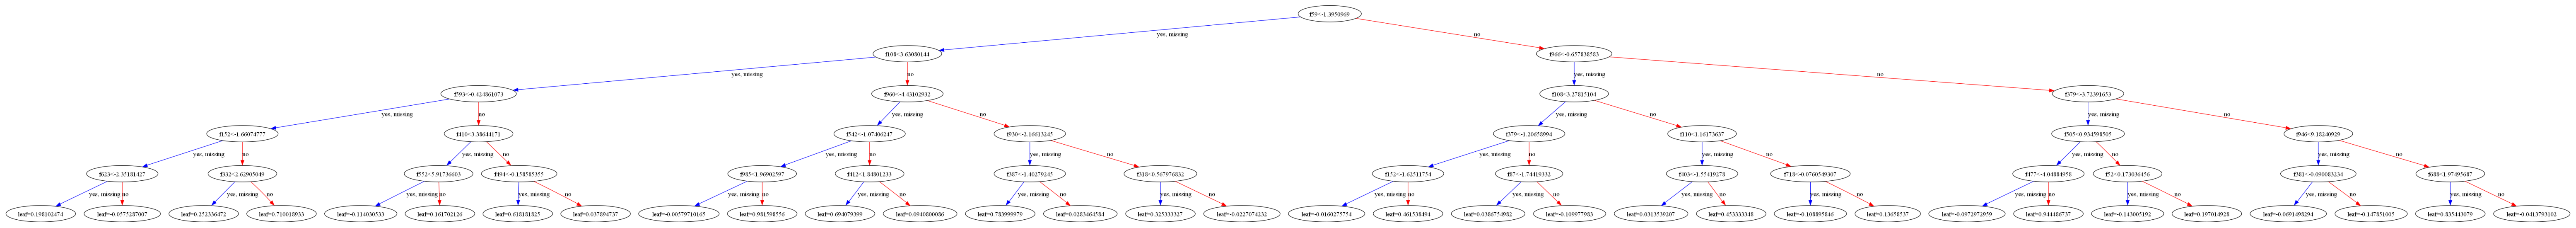

In [29]:
fig, ax = plt.subplots(figsize=(80, 80))
xgb.plot_tree(best_model, num_trees=4, ax=ax)
plt.show()

## RIDGE CLASSIFICATION

d:\App\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.28595e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\App\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.0661e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\App\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.1453e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\App\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.00905e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\App\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.22609e-08): result may not be accurate.
  

Best Model: RidgeClassifier(alpha=10.0, solver='saga')


d:\App\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\App\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\App\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\App\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\App\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\App\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\App\Lib\site-packages\sklearn\linear_

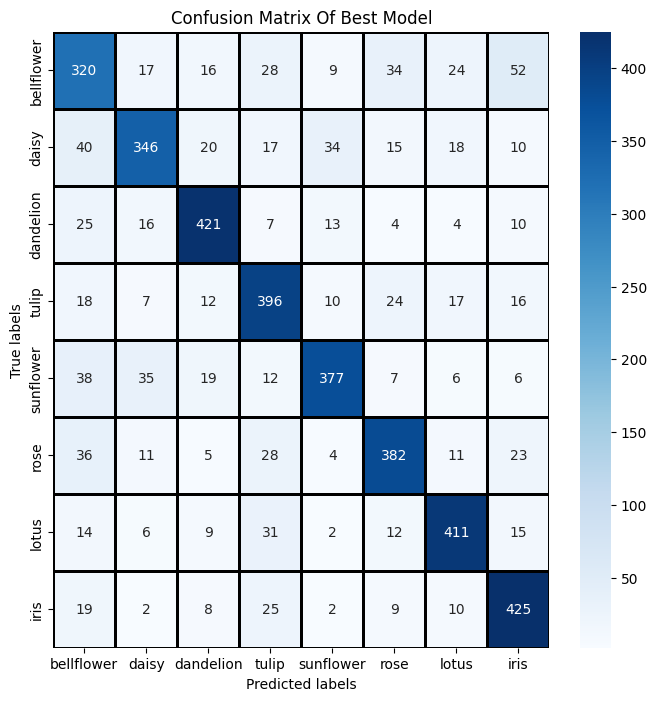

,precision,recall,f1-score,support
bellflower,0.627451,0.6400,0.633663,500.0000
daisy,0.786364,0.6920,0.736170,500.0000
dandelion,0.825490,0.8420,0.833663,500.0000
tulip,0.727941,0.7920,0.758621,500.0000
sunflower,0.835920,0.7540,0.792850,500.0000
rose,0.784394,0.7640,0.774063,500.0000
lotus,0.820359,0.8220,0.821179,500.0000
iris,0.763016,0.8500,0.804163,500.0000
accuracy,0.769500,0.7695,0.769500,0.7695
macro avg,0.771367,0.7695,0.769296,4000.0000


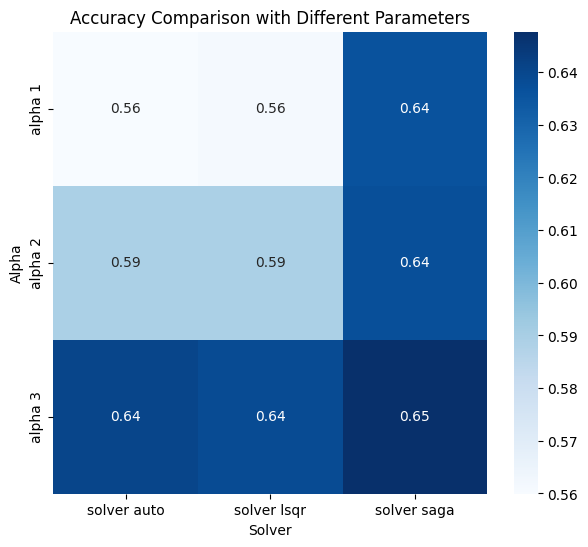

In [30]:
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'solver': ['auto', 'lsqr', 'saga']
}
ridge_classifier = RidgeClassifier()
grid_search = GridSearchCV(estimator=ridge_classifier, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_val, y_val)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
best_model.fit(x_train_temp,y_train_temp)
y_pred = best_model.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()
mean_test_scores = grid_search.cv_results_['mean_test_score']
parameters = grid_search.cv_results_['params']
data = pd.DataFrame(
    np.array(mean_test_scores).reshape(len(param_grid['alpha']), len(param_grid['solver'])),
    index=[f'alpha {i+1}' for i in range(len(param_grid['alpha']))],
    columns=[f'solver {j}' for j in param_grid['solver']])
plt.figure(figsize=(7, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel('Solver')
plt.ylabel('Alpha')
plt.title('Accuracy Comparison with Different Parameters')
plt.show()


In [31]:
y_pred=best_model.predict(x_test_color)
report_plot = ClassificationReportPlot(labels, y_test_color, y_pred)
report_plot.plot()

,precision,recall,f1-score,support
bellflower,0.385965,0.30800,0.342603,500.00000
daisy,0.486000,0.48600,0.486000,500.00000
dandelion,0.609626,0.22800,0.331878,500.00000
tulip,0.407867,0.78800,0.537517,500.00000
sunflower,0.421260,0.85600,0.564644,500.00000
rose,0.649819,0.36000,0.463320,500.00000
lotus,0.627615,0.30000,0.405954,500.00000
iris,0.653846,0.54400,0.593886,500.00000
accuracy,0.483750,0.48375,0.483750,0.48375
macro avg,0.530250,0.48375,0.465725,4000.00000


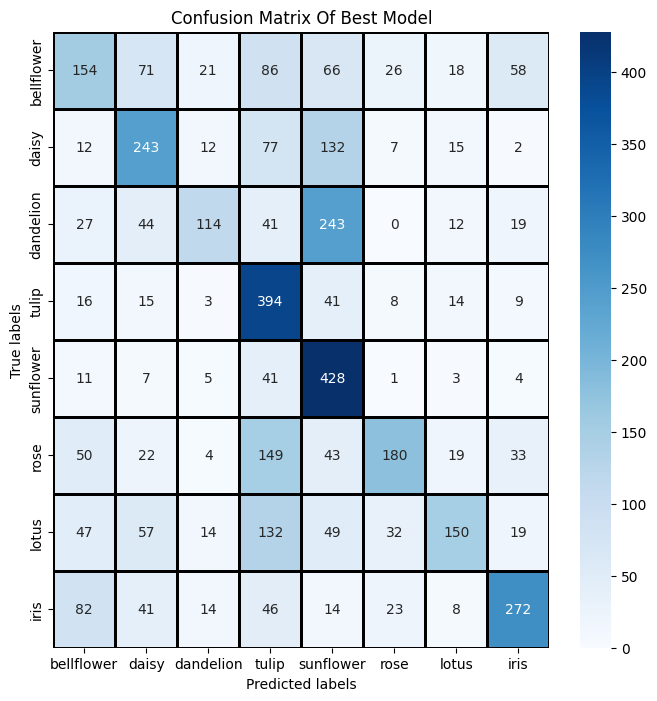

,precision,recall,f1-score,support
bellflower,0.385965,0.30800,0.342603,500.00000
daisy,0.486000,0.48600,0.486000,500.00000
dandelion,0.609626,0.22800,0.331878,500.00000
tulip,0.407867,0.78800,0.537517,500.00000
sunflower,0.421260,0.85600,0.564644,500.00000
rose,0.649819,0.36000,0.463320,500.00000
lotus,0.627615,0.30000,0.405954,500.00000
iris,0.653846,0.54400,0.593886,500.00000
accuracy,0.483750,0.48375,0.483750,0.48375
macro avg,0.530250,0.48375,0.465725,4000.00000


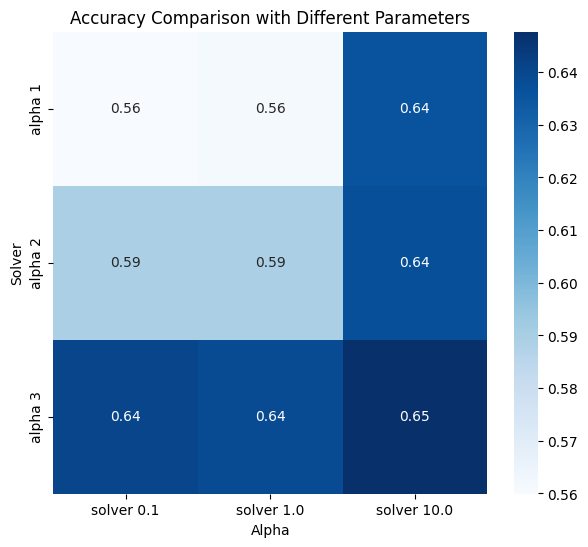

In [33]:
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()
mean_test_scores = grid_search.cv_results_['mean_test_score']
parameters = grid_search.cv_results_['params']
data = pd.DataFrame(
    np.array(mean_test_scores).reshape(len(param_grid['alpha']), len(param_grid['solver'])),
    index=[f'alpha {i+1}' for i in range(len(param_grid['solver']))],
    columns=[f'solver {j}' for j in param_grid['alpha']])
plt.figure(figsize=(7, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel('Alpha')
plt.ylabel('Solver')
plt.title('Accuracy Comparison with Different Parameters')
plt.show()

## NEURAL NETWORK

In [ ]:
n_encoder = OneHotEncoder(sparse=False)
n_encoder.fit(y_train.reshape(-1,1))
e_train_Y = n_encoder.transform(y_train.reshape(-1,1))
e_test_Y = n_encoder.transform(y_test.reshape(-1,1))

d:\App\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
def create_model():
    model = Sequential()
    model.add(Dense(256, input_dim=1000, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(8, kernel_regularizer=l2(0.1), activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
                 loss="categorical_hinge")
    return model

model1 = create_model()
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               256256    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 258,312
Trainable params: 258,312
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epoch = 50
history = model1.fit(x_train, e_train_Y, validation_split = 0.15, epochs=epoch, batch_size=64, verbose=1)

Epoch 1/50
188/188 [==============================] - 10s 52ms/step - loss: 2.3471 - val_loss: 1.6978
Epoch 2/50
188/188 [==============================] - 10s 55ms/step - loss: 1.5900 - val_loss: 1.3571
Epoch 3/50
188/188 [==============================] - 12s 63ms/step - loss: 1.2704 - val_loss: 1.1081
Epoch 4/50
188/188 [==============================] - 13s 67ms/step - loss: 1.0321 - val_loss: 0.9099
Epoch 5/50
188/188 [==============================] - 12s 65ms/step - loss: 0.8532 - val_loss: 0.7549
Epoch 6/50
188/188 [==============================] - 12s 65ms/step - loss: 0.7093 - val_loss: 0.6344
Epoch 7/50
188/188 [==============================] - 12s 65ms/step - loss: 0.5979 - val_loss: 0.5394
Epoch 8/50
188/188 [==============================] - 13s 71ms/step - loss: 0.5139 - val_loss: 0.4733
Epoch 9/50
188/188 [==============================] - 13s 71ms/step - loss: 0.4470 - val_loss: 0.4205
Epoch 10/50
188/188 [==============================] - 12s 66ms/step - loss: 0.398

(Text(0.5, 0, 'epoch'),)

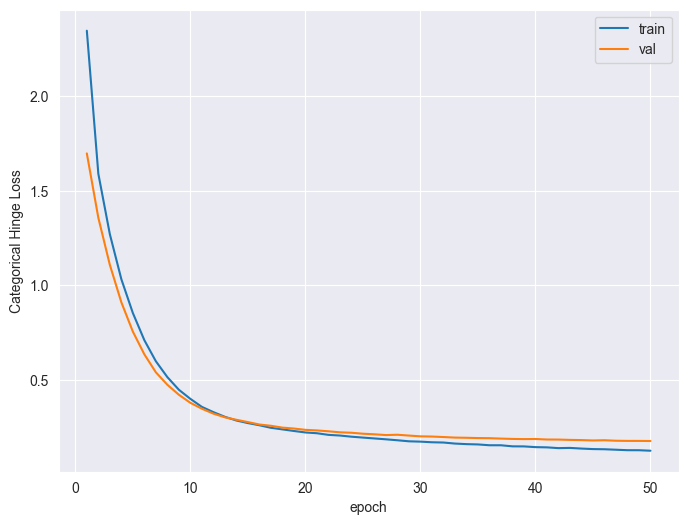

In [ ]:
sea.set_style("darkgrid")
e = np.linspace(1, epoch, epoch)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
sea.lineplot(x = e, y = history.history["loss"],
             ax=axes, label="train"),
sea.lineplot(x = e, y = history.history["val_loss"],
             ax=axes, label="val"),
axes.set_ylabel("Categorical Hinge Loss")
axes.set_xlabel("epoch"),

In [ ]:
y_pred = model1.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)
confusion_plot = ConfusionMatrixPlot(y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(y_test, y_pred)
report_plot.plot()

126/126 [==============================] - 2s 18ms/step


TypeError: ConfusionMatrixPlot.__init__() missing 1 required positional argument: 'y_pred'

In [ ]:
#Chuyển mảng x thành mảng 2 chiều
 ## x_2d = np.reshape(x, (-1, 1))

# Tạo DataFrame từ mảng và label
## data = pd.DataFrame({'features': x_2d.ravel(), 'labels': y})

# Lưu DataFrame vào file CSV
## data.to_csv('processed_data.csv', index=False)


## COMPARE


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

[97.12, 96.15, 95.19, 98.08]


FileNotFoundError: [Errno 2] No such file or directory: '../pics/Test/test_supervised.svg'

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

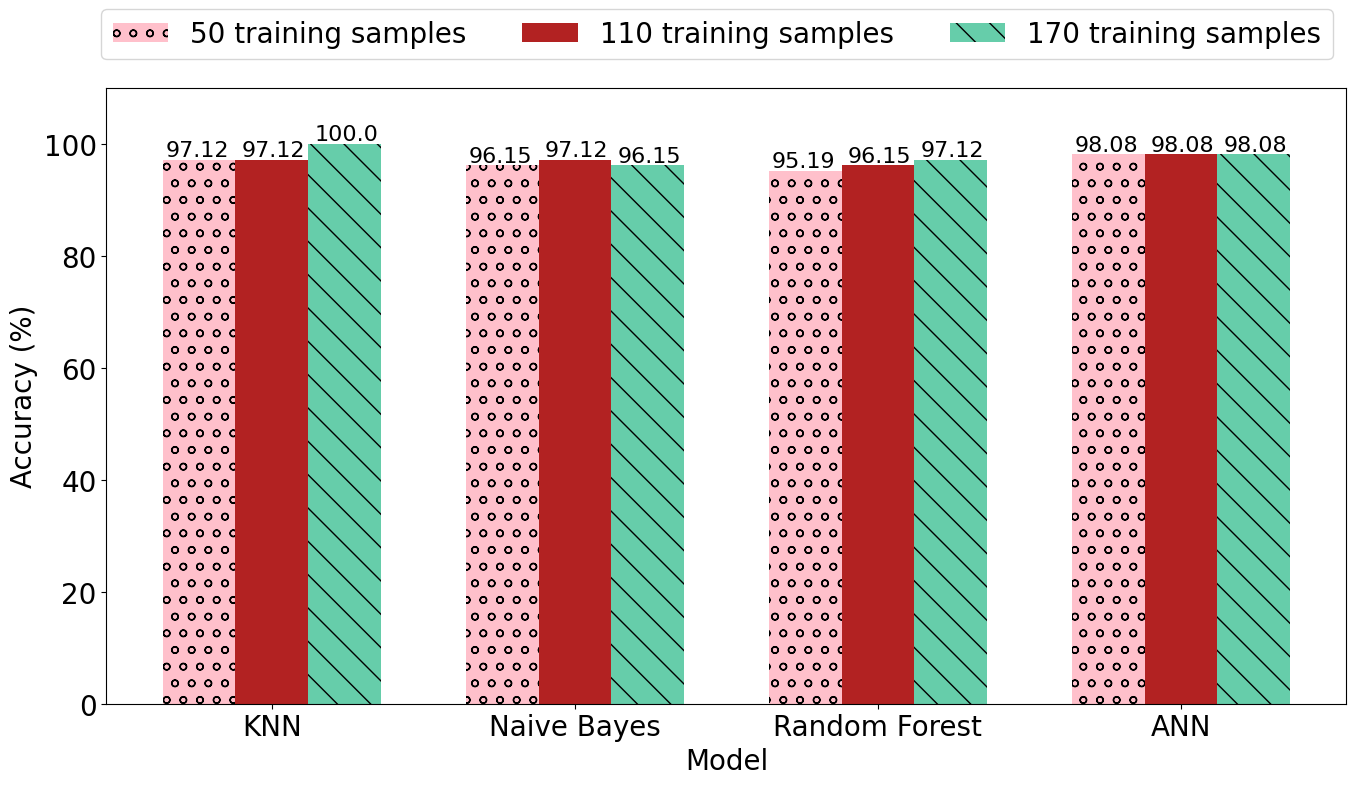

In [ ]:
from matplotlib import pyplot as plt
plt.style.use('default')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)

objects = ('KNN', 'Naive Bayes', 'Random Forest', 'ANN')
y_pos = np.arange(len(objects))
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['font.size'] = '20'

training_samples1 = [97.12,96.15,95.19, 98.08]
training_samples_2 = [97.12,97.12,96.15, 98.08]
training_samples_3 = [100.0,96.15,97.12, 98.08]

for index, value in enumerate(training_samples1):
    plt.text(index - 0.35, value + 0.6, str(value), fontsize=16)
for index, value in enumerate(training_samples_2):
    plt.text(index - 0.1, value + 0.6, str(value), fontsize=16)
for index, value in enumerate(training_samples_3):
    plt.text(index + 0.14, value + 0.6, str(value), fontsize=16)
    
# for index, value in enumerate(min_rewardVSs):
#     plt.text(index + 0.25, value + 0.1, str("{:.3f}".format(value)), fontsize=14)
#plt.bar(y_pos, performance, align='center', alpha=0.5)

print(training_samples1)
bars_sigmoid = plt.bar(y_pos - 0.24, training_samples1, 0.24, label = '50 training samples', color = 'pink')
plt.bar(y_pos, training_samples_2, 0.24, label = '110 training samples', color = 'firebrick')
bars_linear = plt.bar(y_pos + 0.24, training_samples_3, 0.24, label = '170 training samples', color = 'mediumaquamarine')

plt.xticks(y_pos, objects)
plt.ylim([0, 110])
patterns = ("o", "o", "o", "o")
for i, x in zip(bars_sigmoid,patterns):
      i.set_hatch(x)
patterns = ("\\", "\\", "\\", "\\")
for i, x in zip(bars_linear,patterns):
      i.set_hatch(x)
plt.legend(fontsize = 20, bbox_to_anchor =(1, 1.15), ncol = 3)
#plt.margins(0.1,0)
plt.ylabel('Accuracy (%)')
plt.xlabel('Model')
plt.savefig('../pics/Test/test_supervised.svg', bbox_inches='tight')
plt.savefig('../pics/Test/test_supervised.pdf', bbox_inches='tight')
plt.show()
